In [13]:
import os
import argparse
import numpy as np
import cv2
import tifffile
import h5py
from glob import glob
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [14]:
# ======================== 参数配置 ========================
parser = argparse.ArgumentParser()
parser.add_argument('--src_dir', type=str,
                    default='./data/Rock/RawData',
                    help='原始数据目录，包含images和masks子目录')
parser.add_argument('--dst_dir', type=str,
                    default='./data/Rock/Processed',
                    help='预处理结果保存目录')
parser.add_argument('--img_size', type=int,
                    default=1024,
                    help='输出图像尺寸（正方形）')
parser.add_argument('--test_ratio', type=float,
                    default=0.2,
                    help='验证集比例 (0.0~1.0)')
parser.add_argument('--ct_min', type=float,
                    default=0,
                    help='CT值归一化下限(HU)')
parser.add_argument('--ct_max', type=float,
                    default=255,
                    help='CT值归一化上限(HU)')
parser.add_argument('--use_normalize', action='store_true',
                    help='是否进行CT值归一化')
args = parser.parse_args(['--src_dir', './data/Rock/RawData', '--img_size', '1024'])

# 新段落

In [20]:
# ======================== 预处理函数 ========================
def process_slice(image_path, label_path):
    """处理单个切片"""
    # 读取数据
    image = tifffile.imread(image_path)    # (H, W)
    mask = np.array(Image.open(label_path)) # (H, W)
    print(f"[预处理前] 图像范围: {image.min()} ~ {image.max()}")  # 预期应为非零范围（如 0-255）

    # 调整尺寸
    image = cv2.resize(image, (args.img_size, args.img_size), interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (args.img_size, args.img_size), interpolation=cv2.INTER_NEAREST)

    # 归一化处理

    image = np.clip(image, args.ct_min, args.ct_max)
    image = (image - args.ct_min) / (args.ct_max - args.ct_min)
    print(f"[预处理后] 图像范围: {image.min()} ~ {image.max()}")  # 预期应为 0.0 ~ 1.0

    # 转换为三通道
    image_rgb = np.stack([image]*3, axis=-1)  # (H, W, 3)

    return image_rgb.astype(np.float32), mask.astype(np.uint8)

In [17]:
def preprocess_train_image(image_files, label_files):
    """处理训练集（保存为NPZ）"""
    os.makedirs(f"{args.dst_dir}/train_npz", exist_ok=True)

    for img_path, lbl_path in tqdm(zip(image_files, label_files), desc="处理训练集"):
        # 从文件名中提取案例ID（例如5-10101.tif → case5_10101）
        case_id = os.path.basename(img_path).split('.')[0].replace('-', '_')

        # 处理并保存
        image, mask = process_slice(img_path, lbl_path)
        np.savez(
            f"{args.dst_dir}/train_npz/{case_id}.npz",
            image=image,
            label=mask
        )

In [18]:
def preprocess_valid_image(image_files, label_files):
    """处理验证集（保存为HDF5）"""
    os.makedirs(f"{args.dst_dir}/test_vol_h5", exist_ok=True)

    # 遍历所有验证集样本
    for img_path, lbl_path in tqdm(zip(image_files, label_files), desc="处理验证集"):
        # 提取案例ID（例如5-10101.tif → case5_10101）
        case_id = os.path.basename(img_path).split('.')[0].replace('-', '_')

        # 处理切片
        image, mask = process_slice(img_path, lbl_path)

        # 保存为HDF5（每个案例单独保存，即使只有单切片）
        with h5py.File(f"{args.dst_dir}/test_vol_h5/{case_id}.h5", 'w') as f:
            f.create_dataset('image', data=image[np.newaxis, ...], dtype='float32')  # (1, H, W, 3)
            f.create_dataset('label', data=mask[np.newaxis, ...], dtype='uint8')     # (1, H, W)

In [21]:
# ======================== 主执行逻辑 ========================
if __name__ == "__main__":
    # 获取所有文件路径
    image_files = sorted(glob(f"{args.src_dir}/images/*.tif"))
    label_files = sorted(glob(f"{args.src_dir}/masks/*.png"))

    # 验证文件匹配
    assert len(image_files) == len(label_files), "图像与标注文件数量不匹配"

    # 划分训练集/验证集
    train_img, val_img, train_lbl, val_lbl = train_test_split(
        image_files, label_files,
        test_size=args.test_ratio,
        random_state=42
    )

    # 执行预处理
    preprocess_train_image(train_img, train_lbl)
    # preprocess_valid_image(val_img, val_lbl)

    print(f"预处理完成！结果保存在: {args.dst_dir}")


处理训练集: 2it [00:00, 11.00it/s]

[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0
[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0
[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0


处理训练集: 4it [00:00, 11.74it/s]

[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0
[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0
[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0


处理训练集: 8it [00:00, 12.62it/s]

[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0
[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0
[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0
[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0


处理训练集: 11it [00:01,  5.44it/s]

[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0
[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0


处理训练集: 14it [00:01,  7.37it/s]

[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0
[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0
[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0


处理训练集: 16it [00:02,  8.71it/s]

[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0
[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0
[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0


处理训练集: 20it [00:02,  6.50it/s]

[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0
[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0
[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0


处理训练集: 22it [00:03,  7.70it/s]

[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0
[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0
[预处理前] 图像范围: 0 ~ 255
[预处理后] 图像范围: 0.0 ~ 1.0


处理训练集: 24it [00:03,  7.57it/s]

预处理完成！结果保存在: ./data/Rock/Processed


# 检查生成的训练集数据集数据shape

In [26]:
    # 检查NPZ文件
    data = np.load("./data/Rock/Processed/train_npz/5_10101.npz")
    print(data["image"].shape)  # 应输出 (1024, 1024, 3)
    print(data["label"].shape)  # 应输出 (1024, 1024)

    # 检查HDF5文件
    with h5py.File("./data/Rock/Processed/test_vol_h5/5_10109.h5", "r") as f:
        print(f["image"].shape)  # 如 (50, 1024, 1024, 3) 表示50个切片
        print(f["label"].dtype)  # 应为 uint8


(1024, 1024, 3)
(1024, 1024)
(1, 1024, 1024, 3)
uint8


# 检查图片的数值范围

In [ ]:
# check_hu_range.py
import os
import numpy as np
import tifffile
from glob import glob
from tqdm import tqdm

def main():
    # 配置路径（与预处理脚本一致）
    src_dir = "./data/Rock/RawData"  # 替换为实际路径
    image_files = glob(f"{src_dir}/images/*.tif") + glob(f"{src_dir}/images/*.tiff")

    # 初始化统计值
    global_min = np.inf
    global_max = -np.inf

    # 遍历所有图像
    for img_path in tqdm(image_files, desc="分析CT图像"):
        image = tifffile.imread(img_path)
        global_min = min(global_min, image.min())
        global_max = max(global_max, image.max())

    # 在 check_hu_range.py 中添加调试代码
    print("找到的图像文件列表:", image_files)
    print(f"全局统计结果：")
    print(f"  - 最小HU值: {global_min}")
    print(f"  - 最大HU值: {global_max}")
    print(f"建议预处理参数：")
    print(f"  --ct_min {max(global_min, -2000)}  --ct_max {min(global_max, 4000)}")

if __name__ == "__main__":
    main()

分析CT图像: 100%|██████████| 5/5 [00:00<00:00, 252.12it/s]

找到的图像文件列表: ['./data/Rock/RawData/images/5-10104.tif', './data/Rock/RawData/images/5-10103.tif', './data/Rock/RawData/images/5-10105.tif', './data/Rock/RawData/images/5-10101.tif', './data/Rock/RawData/images/5-10102.tif']
全局统计结果：
  - 最小HU值: 0
  - 最大HU值: 255
建议预处理参数：
  --ct_min 0  --ct_max 255


In [10]:
import numpy as np
data = np.load("./data/Rock/Processed/train_npz/5_10101.npz")
image_sample = data['image']
print(f"文件中的图像范围: {image_sample.min()} ~ {image_sample.max()}")


文件中的图像范围: 0.0 ~ 255.0


# 挂载云盘操作步骤

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
path = "/content/drive/MyDrive/SAM/SAMck"
os.chdir(path)
print(os.getcwd())

/content/drive/MyDrive/SAM/SAMck


In [8]:
!git clone https://github.com/Crane-c/SAMck.git

Cloning into 'SAMck'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 104 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (104/104), 11.00 MiB | 4.55 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (90/90), done.


# 代码运行

## 清空之前的训练集和验证集

In [12]:
import os
import shutil

def clear_folder(folder_path):
    """安全清空文件夹（保留文件夹本身，删除所有子文件和子目录）"""
    # 确保路径存在
    if not os.path.exists(folder_path):
        raise ValueError(f"路径不存在: {folder_path}")

    # 遍历删除所有内容
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # 删除文件或符号链接
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # 删除子目录及其内容
        except Exception as e:
            print(f"删除 {file_path} 失败: {e}")

# 使用示例
clear_folder("./data/Rock/Processed")
clear_folder("./lists/lists_Rock")

## 生成训练集、验证集，并生成对应的lists

In [13]:
!python3 preprocess/preprocess_data.py --use_normalize

处理训练集: 6it [00:00, 10.68it/s]
处理验证集: 2it [00:00, 12.67it/s]
预处理完成！结果保存在: ./data/Rock/Processed


In [15]:
import os
import argparse

def extract_filenames(input_dir, output_file):
    # 获取目录中所有文件的文件名（不含后缀）
    filenames = []
    for entry in os.listdir(input_dir):
        entry_path = os.path.join(input_dir, entry)
        if os.path.isfile(entry_path):
            # 分割文件名和后缀，只保留文件名部分
            name_without_ext = os.path.splitext(entry)[0]
            filenames.append(name_without_ext)

    # 写入到输出文件
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(filenames))
    print(f"成功提取 {len(filenames)} 个文件名到 {output_file}")

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='提取文件名到文本文件')
    parser.add_argument('-i', '--input_dir', required=True, help='需要处理的目录路径')
    parser.add_argument('-o', '--output', default='filenames.txt', help='输出文件名（默认：filenames.txt）')

    args = parser.parse_args(['-i', './data/Rock/Processed/train_npz', '-o', './lists/lists_Rock/train.txt'])
    #args = parser.parse_args(['-i', './data/Rock/Processed/test_vol_h5', '-o', './lists/lists_Rock/test_vol.txt'])

    # 验证输入目录是否存在
    if not os.path.isdir(args.input_dir):
        print(f"错误：目录 {args.input_dir} 不存在")
        exit(1)

    extract_filenames(args.input_dir, args.output)

成功提取 6 个文件名到 ./lists/lists_Rock/train.txt


## colab重连配置的环境

In [6]:
!pip install icecream
!pip install tensorboardX
!pip install medpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 19.0 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-py3-none-any.whl size=224709 sha256=81a2433642a7b9e48a53fc5b382aa1907ac483273631345604a8c52ad4f7efc8
  Stored in directory: /root/.cache/pip/wheels/d4/33/ed/aaac5a347fb8d41679ca515b8f5c49dfdf49be15bdbb9a905d
Successfully built medpy


In [14]:
!sha256sum checkpoints/sam_vit_b_01ec64.pth

ec2df62732614e57411cdcf32a23ffdf28910380d03139ee0f4fcbe91eb8c912  checkpoints/sam_vit_b_01ec64.pth


In [1]:
import tensorflow as tf

# 检查 GPU 是否可用
print("GPU 是否可用:", tf.config.list_physical_devices('GPU'))

# 查看 CUDA 版本（需先安装 TensorFlow）
from tensorflow.python.platform import build_info
print("CUDA 版本:", build_info.build_info["cuda_version"])

GPU 是否可用: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA 版本: 12.5.1


## 训练和测试

In [16]:
!python train.py --batch_size 2 --max_epochs 15

/content/drive/MyDrive/SAM/SAMck/segment_anything/build_sam.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)
Namespace(root_path='./data/Rock

In [9]:
!python test.py --volume_path ./data/Rock/Processed/test_vol_h5/

/content/drive/My Drive/SAM/SAMck/segment_anything/build_sam.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)
Traceback (most recent call las

# DINO

In [4]:
import os
path = "/content/drive/MyDrive/DINOv2Geo/DINOv2-X-Geosciences"
os.chdir(path)
print(os.getcwd())

/content/drive/MyDrive/DINOv2Geo/DINOv2-X-Geosciences


In [18]:
!git clone https://github.com/FloFive/DINOv2-X-Geosciences.git

Cloning into 'DINOv2-X-Geosciences'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 162 (delta 91), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (162/162), 3.56 MiB | 12.29 MiB/s, done.
Resolving deltas: 100% (91/91), done.


# 数据处理，分别将数据集中的图片和标签打包成npy

In [2]:
import os
import sys
import numpy as np
from PIL import Image
from tqdm import tqdm
import glob
import random
from google.colab import drive

# Define the project directory path
project_dir = '/content/drive/MyDrive/DINOv2Geo/DINOv2-X-Geosciences'

In [20]:
def custom_tiff_2_npy(project_dir, tiff_folder, dataset_name, npy_name):
    input_dir = os.path.join(project_dir, tiff_folder, dataset_name)
    save_directory = os.path.join(project_dir, 'npy_data', npy_name)

    # 创建输出目录
    os.makedirs(save_directory, exist_ok=True)

    # 获取配对文件
    img_dir = os.path.join(input_dir, 'images')
    mask_dir = os.path.join(input_dir, 'masks')

    # 构建文件名映射字典（核心改进部分）
    img_files = {}
    for f in os.listdir(img_dir):
        if f.lower().endswith(('.tif', '.tiff')):
            base = f.split(".")[0]  # 提取 x-xxxxx
            img_files[base] = os.path.join(img_dir, f)

    mask_files = {}
    for f in os.listdir(mask_dir):
        if f.lower().endswith('.png'):
            base = f.replace("_Simple Segmentation", "").split(".")[0]  # 去除后缀
            # print(base)
            mask_files[base] = os.path.join(mask_dir, f)

    print("图像文件基名:", img_files.keys())
    print("掩码文件基名:", mask_files.keys())
    # 验证匹配关系
    common_keys = set(img_files.keys()) & set(mask_files.keys())
    if not common_keys:
        missing_img = set(mask_files.keys()) - set(img_files.keys())
        missing_mask = set(img_files.keys()) - set(mask_files.keys())
        raise ValueError(f"配对失败:\n 缺失图像的mask:{missing_img}\n 缺失mask的图像:{missing_mask}")

    # 构建配对列表
    file_pairs = [(img_files[key], mask_files[key]) for key in common_keys]
    random.shuffle(file_pairs)

    # 加载数据
    images = []
    masks = []
    for img_path, mask_path in tqdm(file_pairs, desc="处理文件"):
        # 加载图像
        img = np.array(Image.open(img_path).convert('RGB'))

        # 处理mask
        mask = np.array(Image.open(mask_path).convert('L'))  # 确保转换为单通
        # 数值校验
        unique_values = np.unique(mask)
        print(unique_values)
        invalid_values = set(unique_values) - {1,2,3,4}
        if invalid_values:
          raise ValueError(f"发现无效标签值 {invalid_values} 在文件 {mask_path}。"
                        "有效标签应为1,2,3,4")
        mask = mask.astype(np.uint8)

        images.append(img)
        masks.append(mask)

    # 保存numpy文件
    np.save(os.path.join(save_directory, f"{dataset_name}_img.npy"), np.array(images))
    np.save(os.path.join(save_directory, f"{dataset_name}_mask.npy"), np.array(masks))

In [21]:
# 文件结构示例：
# project_dir/
# └── data_test/
#     └── sample2/
#         ├── images/
#         │   ├── 1-00001.tif
#         │   └── 1-00002.tif
#         └── masks/
#             ├── 1-00001_Simple Segment.png
#             └── 1-00002_Simple Segment.png

npy_name = "rock_npy"
dataset_name = "sample1"
tiff_folder = 'data'  # input folder, should contain dataset_name/images and dataset_name/masks

custom_tiff_2_npy(project_dir, tiff_folder, dataset_name, npy_name)

图像文件基名: dict_keys(['5-10101', '5-10104', '5-10105', '5-10102', '5-10103'])
掩码文件基名: dict_keys(['5-10103', '5-10104', '5-10102', '5-10101', '5-10105'])


处理文件:  20%|██        | 1/5 [00:00<00:03,  1.16it/s]

[1 2 3 4]
[1 2 3 4]


处理文件:  60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

[1 2 3 4]


处理文件: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

[1 2 3 4]
[1 2 3 4]


## 验证数据格式和像素标签对应关系等

In [18]:
import numpy as np
import os
import sys

def check_npy_shape(file_path):
    """
    检查.npy文件的形状并打印结果
    Args:
        file_path (str): .npy文件路径
    """
    try:
        data = np.load(file_path)
        print(f"\n{'='*40}")
        print(f"File: {os.path.abspath(file_path)}")
        print(f"Shape: {data.shape}")
        print(f"Datatype: {data.dtype}")
        print(f"Min/Max Value: {data.min()}, {data.max()}")

        # 维度格式判断
        if data.ndim == 3:
            print("Format: (Height, Width, Channels)")
        elif data.ndim == 4:
            print("Format: (Batch, Height, Width, Channels)")
        elif data.ndim == 2:
            print("Format: (Height, Width)")
        else:
            print("️⚠️ 异常维度格式")

    except Exception as e:
        print(f"\n❌ 读取失败: {file_path}")
        print(f"错误类型: {type(e).__name__}")
        print(f"错误详情: {str(e)}")

def process_folder(folder_path):
    """
    处理文件夹中的所有npy文件
    Args:
        folder_path (str): 包含npy文件的文件夹路径
    """
    # 获取所有npy文件
    npy_files = [
        f for f in os.listdir(folder_path)
        if f.endswith('.npy') and os.path.isfile(os.path.join(folder_path, f))
    ]

    if not npy_files:
        print(f"\n🔍 文件夹中没有找到npy文件: {folder_path}")
        return

    print(f"\n📂 正在扫描文件夹: {os.path.abspath(folder_path)}")
    print(f"🔎 找到 {len(npy_files)} 个npy文件")

    # 处理每个文件
    for filename in npy_files:
        file_path = os.path.join(folder_path, filename)
        check_npy_shape(file_path)

if __name__ == "__main__":

    target_folder = "./npy_data/rock_npy"

    # 验证文件夹是否存在
    if not os.path.isdir(target_folder):
        print(f"\n❌ 路径不存在或不是文件夹: {target_folder}")
        sys.exit(2)

    # 执行扫描
    process_folder(target_folder)


📂 正在扫描文件夹: /content/drive/My Drive/DINOv2Geo/DINOv2-X-Geosciences/npy_data/rock_npy
🔎 找到 2 个npy文件

File: /content/drive/My Drive/DINOv2Geo/DINOv2-X-Geosciences/npy_data/rock_npy/sample1_img.npy
Shape: (5, 1012, 992, 3)
Datatype: uint8
Min/Max Value: 0, 255
Format: (Batch, Height, Width, Channels)

File: /content/drive/My Drive/DINOv2Geo/DINOv2-X-Geosciences/npy_data/rock_npy/sample1_mask.npy
Shape: (5, 1012, 992)
Datatype: uint8
Min/Max Value: 1, 4
Format: (Height, Width, Channels)


In [19]:
!pwd

/content/drive/My Drive/DINOv2Geo/DINOv2-X-Geosciences


In [20]:
from PIL import Image
import numpy as np

def print_mask_info(mask_path):
    # 读取mask文件
    mask = np.array(Image.open(mask_path).convert('L'))

    # 获取唯一像素值
    unique_values = np.unique(mask)
    print(f"文件 {mask_path} 中的唯一像素值：{unique_values}")

    # 打印值分布
    for val in unique_values:
        count = np.sum(mask == val)
        print(f"值 {val} 出现的次数：{count}")

# 使用示例
print_mask_info('./data/sample1/masks/5-10101_Simple Segmentation.png')

文件 ./data/sample1/masks/5-10101_Simple Segmentation.png 中的唯一像素值：[1 2 3 4]
值 1 出现的次数：499681
值 2 出现的次数：129152
值 3 出现的次数：121818
值 4 出现的次数：253253


<ipython-input-21-15da725e9961>:59: UserWarning: Glyph 22266 (\N{CJK UNIFIED IDEOGRAPH-56FA}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, bbox_inches='tight', dpi=300)
<ipython-input-21-15da725e9961>:59: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, bbox_inches='tight', dpi=300)
<ipython-input-21-15da725e9961>:59: UserWarning: Glyph 28082 (\N{CJK UNIFIED IDEOGRAPH-6DB2}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, bbox_inches='tight', dpi=300)
<ipython-input-21-15da725e9961>:59: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAPH-6C14}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, bbox_inches='tight', dpi=300)
<ipython-input-21-15da725e9961>:59: UserWarning: Glyph 32972 (\N{CJK UNIFIED IDEOGRAPH-80CC}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, bbox_inches='tight', dpi=300)
<ipython-input-21-15da725e9961>:59: UserWarning: Glyph 26223 (\N{CJK UNIFIED IDEOGRAP

KeyboardInterrupt: 

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 22266 (\N{CJK UNIFIED IDEOGRAPH-56FA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 28082 (\N{CJK UNIFIED IDEOGRAPH-6DB2}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAPH-6C14}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 32972 (\N{CJK UNIFIED IDEOGRAPH-80CC}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph

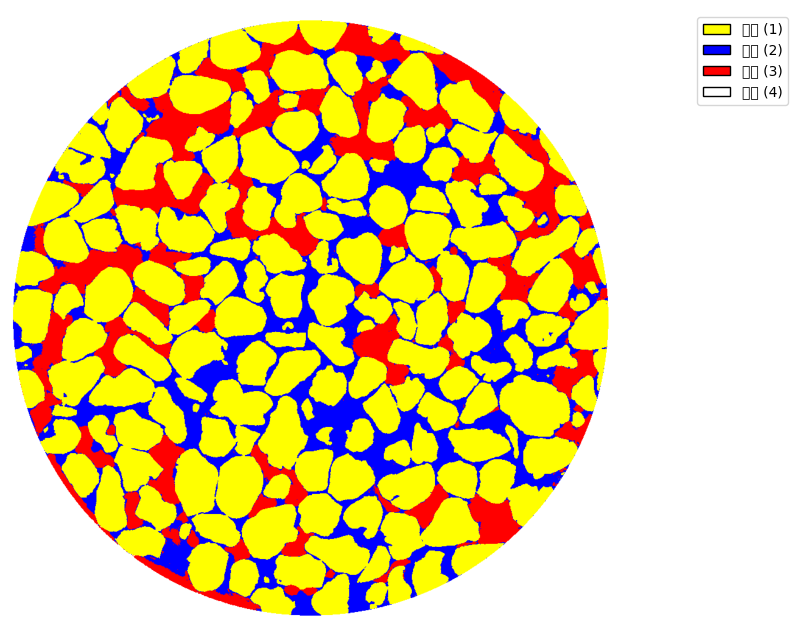

In [21]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def visualize_mask(mask_path, save_path=None):
    """
    可视化mask图像（支持显示和保存）

    参数：
        mask_path: mask文件路径
        save_path: 保存路径（None则仅显示不保存）

    颜色映射：
        1 (固体) : 黄色 (255,255,0)
        2 (液体) : 蓝色 (0,0,255)
        3 (气体) : 红色 (255,0,0)
        4 (背景) : 白色 (255,255,255)
    """
    # 读取mask并转换为numpy数组
    mask = np.array(Image.open(mask_path))

    # 验证像素值范围
    unique_values = np.unique(mask)
    if not set(unique_values).issubset({1,2,3,4}):
        invalid = set(unique_values) - {1,2,3,4}
        raise ValueError(f"发现非法像素值 {invalid}，应为1-4")

    # 创建颜色映射表 (R, G, B)
    color_map = {
        1: [255, 255, 0],   # 黄色
        2: [0, 0, 255],     # 蓝色
        3: [255, 0, 0],     # 红色
        4: [255, 255, 255]  # 白色
    }

    # 创建RGB图像 (height, width, 3)
    rgb_image = np.zeros((*mask.shape, 3), dtype=np.uint8)

    # 向量化颜色映射
    for class_id, color in color_map.items():
        rgb_image[mask == class_id] = color

    # 创建图例
    legend_elements = [
        Patch(facecolor='#FFFF00', edgecolor='black', label='固体 (1)'),
        Patch(facecolor='#0000FF', edgecolor='black', label='液体 (2)'),
        Patch(facecolor='#FF0000', edgecolor='black', label='气体 (3)'),
        Patch(facecolor='#FFFFFF', edgecolor='black', label='背景 (4)')
    ]

    # 可视化
    plt.figure(figsize=(10, 8))
    plt.imshow(rgb_image)
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.axis('off')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"可视化结果已保存至：{save_path}")
    else:
        plt.show()

# 使用示例 ---------------------------------------------------
if __name__ == "__main__":

    # 可视化测试
    visualize_mask("./data/sample1/masks/5-10101_Simple Segmentation.png", save_path="visualized_mask.png")

### 计算均值和标准差

In [ ]:
import os
import numpy as np
from tqdm import tqdm

def compute_stats(image_dir, save_path=None):
    # 初始化统计变量
    pixel_sum = np.zeros(3)
    pixel_sq_sum = np.zeros(3)
    total_pixels = 0  # 总像素数（所有图像的 H*W 之和）

    # 遍历目录下的所有.npy文件
    for filename in tqdm(os.listdir(image_dir)):
        # 跳过隐藏文件和非.npy文件
        if filename.startswith('.') or not filename.endswith('img.npy'):
            continue

        file_path = os.path.join(image_dir, filename)

        # 加载文件 (形状: [N, H, W, C])
        img_data = np.load(file_path)  # dtype应为uint8
        print(img_data.shape)

        # 转换数据类型并归一化到[0,1]
        img_data = img_data.astype(np.float32) / 255.0
        print(img_data.shape)

        # 计算当前文件的总像素数（N张图的H*W之和）
        num_images, h, w, _ = img_data.shape
        current_pixels = num_images * h * w

        # 按通道求和 (axis=(0,1,2) 对N, H, W求和)
        pixel_sum += img_data.sum(axis=(0,1,2))  # 形状: (3,)
        pixel_sq_sum += (img_data ** 2).sum(axis=(0,1,2))

        # 累加总像素数
        total_pixels += current_pixels

    # 计算全局均值和标准差
    mean = pixel_sum / total_pixels
    std = np.sqrt(pixel_sq_sum / total_pixels - mean ** 2)

    if save_path:
        np.save(save_path, {"mean": mean, "std": std})

    return mean, std

# 使用示例
mean, std = compute_stats("./npy_data/rock_npy/")
print(f"Mean: {mean.round(4)}, Std: {std.round(4)}")

## 依赖库和包

In [ ]:
!pip install torchmetrics
!pip install -q -U bitsandbytes
!pip install peft

In [ ]:
# Standard Libraries
import os
import sys
import random
from datetime import datetime


# Transformers Libraries
from transformers import AutoImageProcessor, AutoModel, get_scheduler, BitsAndBytesConfig, AutoFeatureExtractor, ResNetForImageClassification

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms.functional as Fv
from torchvision.datasets import VisionDataset
import torchvision


# PEFT Libraries
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Data Handling Libraries
from dataclasses import dataclass, field
import numpy as np
import torchmetrics

# Progress Bar Library
from tqdm import tqdm

# Plotting Library
import matplotlib.pyplot as plt


## 分割头和模型定义

In [22]:
class LinearHead(nn.Module):
    def __init__(self, embedding_size=768, img_size=560, num_classes=4, n_features=1):
        super(LinearHead, self).__init__()
        self.embedding_size = embedding_size * n_features
        self.n_features = n_features
        self.head = nn.Sequential(
            nn.BatchNorm2d(self.embedding_size),
            nn.Conv2d(self.embedding_size, num_classes, kernel_size=1, padding=0, bias=True),
            nn.Upsample(size=(img_size, img_size), mode='bilinear', align_corners=False)
        )

    def forward(self, inputs):
        features = inputs["features"]
        patch_feature_size = inputs["image"].shape[-1] // 14
        if self.n_features > 1:
            features = torch.cat(features, dim=-1)[:,1:].permute(0,2,1).reshape(-1,self.embedding_size, patch_feature_size, patch_feature_size)
        else:
            features = features[:,1:].permute(0,2,1).reshape(-1,self.embedding_size, patch_feature_size, patch_feature_size)
        logits = self.head(features)
        return logits


In [23]:
@dataclass
class SegmentationHeadConfig:

    embedding_size: int = 768
    n_filter : int = 32
    n_blocks: int = 4
    num_classes : int = 4
    upscale_fn: str = field(default_factory=lambda: ["interpolate", "interpolate", "pixel_shuffle", "pixel_shuffle"])

In [24]:
class CNNHead(nn.Module):
    def __init__(self):
        super(CNNHead, self).__init__()
        channels = 512
        self.config = SegmentationHeadConfig()
        self.input_conv = nn.Conv2d(
            in_channels=self.config.embedding_size,
            out_channels=channels,
            kernel_size=3,
            padding=1
        )
        self.decoder_convs = nn.ModuleList()
        for i in range(self.config.n_blocks):
            if self.config.upscale_fn[i] == "interpolate":
                self.decoder_convs.append(self._create_decoder_conv_block(channels=channels, kernel_size=3, downscale_factor=i))
            else:
                channels = channels // 4
                self.decoder_convs.append(self._create_decoder_up_conv_block(channels=channels, kernel_size=3, downscale_factor=1))

        self.seg_conv = nn.Sequential(
            nn.Conv2d(channels, self.config.num_classes, kernel_size=3, padding=1)
        )

    def _create_decoder_conv_block(self, channels, kernel_size, downscale_factor):
        return nn.Sequential(
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=1),
        )

    def _create_decoder_up_conv_block(self, channels, kernel_size, downscale_factor):
        return nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=1),
        )

    def forward(self, inputs):
        features = inputs["features"]
        patch_feature_size = inputs["image"].shape[-1] // 14
        features = features[:, 1:].permute(0, 2, 1).reshape(-1, self.config.embedding_size, patch_feature_size, patch_feature_size)
        x = self.input_conv(features)

        # 上采样
        for i in range(self.config.n_blocks):
            if self.config.upscale_fn[i] == "interpolate":
                resize_shape = x.shape[-1] * 2 if i >= 1 else x.shape[-1] * 1.75
                x = F.interpolate(input=x, size=(int(resize_shape), int(resize_shape)), mode="bicubic")
            else:
                x = F.pixel_shuffle(x, 2)

            x = x + self.decoder_convs[i](x)

            if i % 2 == 1 and i != 0:
                x = F.dropout(x, p=0.2)
                x = F.leaky_relu(x)

        x = self.seg_conv(x)
        return x

In [25]:
class DinoV2Segmentor(nn.Module):

    head = {
        "linear" : LinearHead,
        "cnn" : CNNHead,
    }

    emb_size = {
        "small" : 384,
        "base" : 768,
        "large" : 1024,
    }

    def __init__(self, num_classes, size="base", n_features=1, peft=False, quantize=False, head_type="linear"):
        super(DinoV2Segmentor, self).__init__()
        assert size in self.emb_size.keys(), "Invalid size"
        assert head_type in self.head.keys(), "Invalid head type"
        if n_features > 1 and head_type=="cnn":
          raise ValueError("Multi feature concatenation with cnn head is not supported currently, feel free to customize the code if required ;)")
        self.num_classes = num_classes
        self.n_features = n_features
        self.peft = peft
        self.embedding_size = self.emb_size[size]
        if quantize :
            self.quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_use_double_quant=True,
                bnb_4bit_compute_dtype=torch.bfloat16,
            )
            self.backbone = AutoModel.from_pretrained(f'facebook/dinov2-{size}', quantization_config=self.quantization_config)
            self.backbone = prepare_model_for_kbit_training(self.backbone)
        else:
            self.backbone = AutoModel.from_pretrained(f'facebook/dinov2-{size}')

        if peft:
            peft_config = LoraConfig(inference_mode=False, r=32, lora_alpha=32, lora_dropout=0.1, target_modules="all-linear", use_rslora=True)
            self.backbone = get_peft_model(self.backbone, peft_config)
            self.backbone.print_trainable_parameters()
        self.seg_head = self.build_head(head_type)
        print(f"Number of parameters: {sum(p.numel() for p in self.parameters() if p.requires_grad)}")

    def forward(self, x, is_training=False):
        # frozen weights of dino
        with torch.set_grad_enabled(self.peft and is_training):
            if self.n_features == 1:
                features = self.backbone(pixel_values=x).last_hidden_state
            else:
                features = list(self.backbone(pixel_values=x, output_hidden_states=True)['hidden_states'])[-self.n_features:]
        inputs = {"features" : features, "image" : x}
        return self.seg_head(inputs)

    def build_head(self, head_type):
        if head_type == "linear":
            return LinearHead(embedding_size=self.embedding_size, num_classes=self.num_classes, n_features=self.n_features)
        elif head_type == "cnn":
            return CNNHead()
        else:
            raise ValueError(f"Invalid head type: {head_type}")

## 数据加载

In [26]:

def load_segmentation_data(data_dir, device, num_samples, img_res, train_rocks, test_rocks, num_classes=4, val_split=0.8, batch_size=2):
    # Initialize the training dataset with specified parameters
    train_dataset = EfficientSegmentationDataset(
        data_dir, train_rocks, num_samples=num_samples, num_classes=num_classes, img_res=img_res
    )
    print(f"训练集样本数：{len(train_dataset)}")

    # Initialize the testing dataset with specified parameters (num_samples set to 30 by default)
    test_dataset = EfficientSegmentationDataset(
        data_dir, test_rocks, num_samples=int(val_split*num_samples), num_classes=num_classes, img_res=img_res
    )
    print(f"测试集样本数：{len(test_dataset)}")

    pin_memory_device = 'cuda'

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, pin_memory_device=pin_memory_device)
    val_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2, pin_memory=True, pin_memory_device=pin_memory_device)

    return {'train': train_loader, 'val': val_loader, 'num_classes': num_classes}

class EfficientSegmentationDataset(VisionDataset):
    def __init__(self, data_dir, rock_names, num_classes=4, num_samples=None, crop_size = (512,512), p=0.5, img_res=224, save_dir=None):
        super().__init__(data_dir, transforms=None)
        print("Loading data ...")
        # The stats have been computed on our side. These values represents the mean and stddev pour each rock dataset
        self.data_stats = {
            "sample1" : [
                np.array([0.4844, 0.4844, 0.4844]), np.array([0.314, 0.314, 0.314])      # 标准差 (已归一化到[0,1])
            ],

        }
        self.img_data = [np.lib.format.open_memmap(data_dir+f"/{rock}_img.npy", dtype=np.uint8, mode='r') for rock in rock_names]
        self.mask_data = [np.lib.format.open_memmap(data_dir+f"/{rock}_mask.npy", dtype=np.uint8, mode='r') for rock in rock_names]
        self.rock_names = rock_names
        self.crop_size=crop_size
        self.p=p
        self.OFFSET = 128
        self.IMG_RES = img_res
        self.save_dir = save_dir
        self.num_classes = num_classes
        self.inference_mode = False

        if num_samples is None:
          self.num_samples = len(self.img_data[0])
        else:
          self.num_samples = num_samples

        self.num_datasets = len(self.img_data)

    def get_random_crop_params(self):
        h, w = (1012, 992)
        th, tw = self.crop_size

        if h < th or w < tw:
            raise ValueError(f"Required crop size {(th, tw)} is larger than input image size {(h, w)}")

        if w == tw and h == th:
            return 0, 0, h, w

        i = torch.randint(0, h - th + 1, size=(1,)).item()
        j = torch.randint(0, w - tw + 1, size=(1,)).item()

        return i, j, th, tw

    def _weights_calc(self, mask, temperature=1.0):
        """
        四分类权重计算函数（像素值1-4对应固/液/气/背景）

        Args:
            mask: 输入mask矩阵，像素值为1-4的整数 (H, W)
            temperature: 温度系数（默认1.0，越小差异越大）

        Returns:
            weights: 四类权重张量，形状为(4,)
        """
        # 验证输入数据
        unique_values = np.unique(mask)
        if not set(unique_values).issubset({1,2,3,4}):
            invalid = set(unique_values) - {1,2,3,4}
            raise ValueError(f"非法像素值 {invalid}，应为1-4")

        # 统计像素值出现次数（索引0对应值0，这里不需要）
        counts = np.bincount(mask.ravel(), minlength=5)[1:5]  # 提取1-4的统计

        # 添加平滑项避免除零（epsilon=1e-6）
        epsilon = 1e-6
        total = np.sum(counts) + 4 * epsilon
        class_ratio = (counts + epsilon) / total

        # 计算逆频率权重
        u_weights = 1.0 / class_ratio

        # 转换为张量并应用温度缩放
        weights_tensor = torch.from_numpy(u_weights).float()
        weights = F.softmax(weights_tensor / temperature, dim=-1)

        # 异常检测
        if torch.any(torch.isnan(weights)):
            error_info = {
                "input_counts": counts.tolist(),
                "class_ratio": class_ratio.tolist(),
                "u_weights": u_weights.tolist()
            }
            raise ValueError(f"权重计算异常，请检查输入数据:\n{error_info}")

        return weights

    def __getitem__(self, idx):
        # random crop
        i, j, h, w = self.get_random_crop_params()
        idx_x = i
        idx_y = j
        if idx_x < self.OFFSET:
            idx_x += self.OFFSET
        if idx_y < self.OFFSET:
            idx_y += self.OFFSET

        # random crop avant d'accéder au memmap
        dataset_index = idx % self.num_datasets
        data_idx = (idx // self.num_datasets)

        img = self.img_data[dataset_index][data_idx, idx_x:h+idx_x, idx_y:w+idx_y, :].copy()
        mask = self.mask_data[dataset_index][data_idx, idx_x:h+idx_x, idx_y:w+idx_y].copy()

        #img = self.non_local_means_filter(img, h=15, templateWindowSize=7, searchWindowSize=21)

        weights = self._weights_calc(mask)

        img = torch.from_numpy(img.transpose((2, 0, 1))).contiguous()/255.0 # forcément en [0 255] car uint8
        mask = torch.from_numpy(mask).contiguous()/4.0

        img = F.interpolate(input=img.unsqueeze(0), size=(self.IMG_RES, self.IMG_RES), mode="bicubic", align_corners=False).squeeze()
        mask = F.interpolate(input=mask.unsqueeze(0).unsqueeze(0), size=(self.IMG_RES, self.IMG_RES), mode="nearest").squeeze()

        # random h flip
        r = torch.rand(1)
        if r < self.p and not self.inference_mode:
            img = torchvision.transforms.functional.hflip(img)
            mask = torchvision.transforms.functional.hflip(mask)

        # random v flip
        r = torch.rand(1)
        if r < self.p and not self.inference_mode:
            img = torchvision.transforms.functional.vflip(img)
            mask = torchvision.transforms.functional.vflip(mask)


        # Random brightness and contrast jittering
        if not self.inference_mode:
            brightness = random.uniform(0.8, 1.2)
            contrast = random.uniform(0.8, 1.2)
            img = torchvision.transforms.functional.adjust_brightness(img, brightness)
            img = torchvision.transforms.functional.adjust_contrast(img, contrast)

        # Adjust gamma
        if not self.inference_mode:
            gamma = random.uniform(0.5, 1.5)
            img = torchvision.transforms.functional.adjust_gamma(img, gamma)

        # normalize
        m = self.data_stats[self.rock_names[dataset_index]][0]
        s = self.data_stats[self.rock_names[dataset_index]][1]

        if self.num_classes > 2:
           mask = (mask* self.num_classes).long()-1

        return torchvision.transforms.functional.normalize(img, m, s).float(), mask, weights, img

    def __len__(self):
        return self.num_datasets * self.num_samples

In [27]:
# Define the path to the numpy data directory. All data are in npy format
dataset_name = "rock_npy"

# Set the device to 'cuda' for GPU usage
device = 'cuda'

# Define the training and testing rock samples
train_rocks = ['sample1']
test_rocks = ["sample1"]

# Set the batch size for data loading
batch_size = 5

# Set the number of epochs for training
epoch_nb = 20

# Specify the size of the model (small, base or large)
size_network = "base"

# Specify segmentation head type (linear or cnn)
head_type = "linear"

# Quantized LoRA ?
peft= True
quantize= True

# Set the image resolution.
img_res = 560

# Set the number of samples to be used for training.
# This number represents the amount of 2D slice that will be randomly selected per dataset (in our case 500*2)
num_samples = 5

# Number of layer of the DINOv2 backbone concatenated before passing the features to the head
n_features = 1

# Using the datasets of Alhammadi et al. (2017), we have 3 classes
num_classes = 4

# Set the learning rate
lr=1e-4

# set the weight decay
weight_decay=1e-4

# Get the number of datasets based on the length of training rocks
num_dataset = len(train_rocks)

# Data loading
data_npy = os.path.join(project_dir, "npy_data", dataset_name)
dataloaders = load_segmentation_data(data_dir=data_npy,
                                     device=device,
                                     img_res=img_res,
                                     num_samples=num_samples,
                                     train_rocks=train_rocks,
                                     test_rocks=test_rocks,
                                     num_classes=num_classes,
                                     batch_size=batch_size)

Loading data ...
训练集样本数：5
Loading data ...
测试集样本数：4


## training

In [29]:
# Define the project directory path
project_dir = "/content/drive/MyDrive/DINOv2Geo/DINOv2-X-Geosciences"

# Add the DinoV2 code directory to the system path for module imports
sys.path.append(os.path.join(project_dir, "code"))

# Define the runs directory path within the project directory
runs_directory = os.path.join(project_dir, 'runs')

# Define the data directory path within the project directory
data_directory = os.path.join(project_dir, 'data')

In [30]:
# Define the directory to save the results
current_time = datetime.now().strftime("%d-%m-%y-%H-%M-%S")
save_directory = runs_directory + f'/DINOv2_{size_network}_{num_samples}_{img_res}_{current_time}/'

if not os.path.exists(save_directory):
    os.makedirs(save_directory)

print(save_directory)

def plot_learning_curves(loss_dict, jaccard_dict, MODEL_FOLDER):
    """
    Plots the learning curves for loss and IoU over epochs.

    Args:
        loss_dict (dict): Dictionary containing loss values for training and validation.
        jaccard_dict (dict): Dictionary containing IoU values for training and validation.
        MODEL_FOLDER (str): Directory to save the plot.
    """
    # Extract epochs and corresponding loss and IoU values
    epochs = list(loss_dict['train'].keys())
    train_loss_values = [loss_dict['train'][epoch] for epoch in epochs]
    val_loss_values = [loss_dict['val'][epoch] for epoch in epochs]
    train_jaccard_values = [jaccard_dict['train']['mean_iou'][epoch - 1] for epoch in epochs]
    val_jaccard_values = [jaccard_dict['val']['mean_iou'][epoch - 1] for epoch in epochs]

    # Create subplots for loss and IoU
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    ax0 = axes[0]
    ax2 = axes[1]

    # Plot loss values
    ax0.plot(epochs, train_loss_values, 'b-', label='train')
    ax0.plot(epochs, val_loss_values, 'r-', label='val')
    ax0.set_title('Loss')
    ax0.set_xlabel('Epochs')
    ax0.set_ylabel('Loss')

    # Plot IoU values
    ax2.plot(epochs, train_jaccard_values, 'b-', label='train')
    ax2.plot(epochs, val_jaccard_values, 'r-', label='val')
    ax2.set_title('IoU')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('%')
    ax2.set_ylim(0.1, 1.0)
    ax2.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_directory, 'learning_curves.png'), dpi=300)

def save_experiment_params(num_samples_train, batch_size, num_dataset, EPOCH_NB, lr, weight_decay, model):
    """
    Saves the experiment parameters and model state dictionary.

    Args:
        num_samples_train (int): Number of training samples.
        batch_size (int): Batch size.
        num_dataset (int): Number of datasets.
        EPOCH_NB (int): Number of epochs.
        lr (float): Learning rate.
        weight_decay (float): Weight decay.
        model (torch.nn.Module): Trained model.
    """
    # Create folder name based on current date and time
    current_time = datetime.now().strftime("%d-%m-%Y-%H-%M")
    folder_name = f'DINOv2-{current_time}'

    # Create the directory if it doesn't exist
    folder_path = os.path.join(save_directory, folder_name)
    os.makedirs(folder_path, exist_ok=True)

    # Save the experiment parameters to a text file
    params_file_path = os.path.join(folder_path, 'experiment_params.txt')
    with open(params_file_path, 'w') as f:
        f.write(f'num_samples_train={num_samples_train}\n')
        f.write(f'batch_size={batch_size}\n')
        f.write(f'num_dataset={num_dataset}\n')
        f.write(f'EPOCH_NB={EPOCH_NB}\n')
        f.write(f'lr={lr}\n')
        f.write(f'weight_decay={weight_decay}\n')

    # Save the model state dict
    model_file_path = os.path.join(folder_path, 'model_state_dict.pth')
    torch.save(model.state_dict(), model_file_path)

def save_dicts(loss_dict, jaccard_dict, file_path):
    """
    Saves the loss and IoU dictionaries as PyTorch tensors.

    Args:
        loss_dict (dict): Dictionary containing loss values for training and validation.
        jaccard_dict (dict): Dictionary containing IoU values for training and validation.
        file_path (str): Directory to save the tensors.
    """
    # Convert dictionaries to PyTorch tensors
    loss_tensor = {
        'train': torch.tensor(list(loss_dict['train'].values())),
        'val': torch.tensor(list(loss_dict['val'].values()))
    }

    jaccard_tensor = {
        'train': torch.tensor(jaccard_dict['train']['mean_iou']),
        'val': torch.tensor(jaccard_dict['val']['mean_iou'])
    }

    # Save tensors to files
    torch.save(loss_tensor, os.path.join(file_path, 'loss_tensor.pt'))
    torch.save(jaccard_tensor, os.path.join(file_path, 'iou_tensor.pt'))

def train_segmentation_model(model, dataloaders, optimizer, scheduler, device, epoch_nb=10):
    """
    Trains the segmentation model.

    Args:
        model (torch.nn.Module): The segmentation model.
        dataloaders (dict): Dictionary containing training and validation dataloaders.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
        device (str): Device to run the training on ('cuda' or 'cpu').
        epoch_nb (int): Number of epochs to train.

    Returns:
        torch.nn.Module: Trained model.
    """
    if device == "cuda":
        scaler = torch.cuda.amp.GradScaler()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True

    jaccard = torchmetrics.classification.MulticlassJaccardIndex(num_classes=3, ignore_index=-1).to(device)

    print('New model')
    epoch_init = 1
    loss_dict = {}
    metrics_dict = {}
    monitored_metrics = ["mean_iou"]
    for phase in ['train', 'val']:
        loss_dict[phase] = {}
        metrics_dict[phase] = {}
        for m in monitored_metrics:
            metrics_dict[phase][m] = []

    best_train_iou = 0
    best_val_iou = 0
    best_val_loss = 100000
    for epoch in range(epoch_init, epoch_init+epoch_nb):
        print('\n')
        print('-' * 18)
        print('--- Epoch {}/{} ---'.format(epoch, epoch_init+epoch_nb-1))

        for phase in ['train', 'val']:
            if phase == 'train':
                is_training = True
                model.train()
            else:
                model.eval()
                is_training = False

            # Initialize metrics for this phase
            running_loss = 0.0  # Accumulate losses over the epoch
            running_iou = 0.0
            with tqdm(total=len(dataloaders[phase]), unit='batch') as p:

                for batch_idx, (inputs, labels, weights, _) in enumerate(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    weights = weights.to(device)
                    optimizer.zero_grad()

                    batch_weights = torch.mean(weights, dim=0)
                    with torch.set_grad_enabled(is_training):
                        with torch.autocast(device_type=device, dtype=torch.float16):
                            outputs = model(inputs, is_training).squeeze()
                            loss = F.cross_entropy(outputs, labels.squeeze(), ignore_index=-1, weight=batch_weights, label_smoothing=0.05)
                            if is_training:
                                if device=="cuda":
                                    scaler.scale(loss).backward()
                                    scaler.step(optimizer)
                                    scaler.update()
                                else:
                                    loss.backward()
                                    optimizer.step()
                                scheduler.step()

                    # Update running loss and correct prediction count
                    running_loss += loss.item()

                    with torch.no_grad():
                        mIoU = jaccard(outputs, labels.squeeze())#mean_iou.compute(predictions=preds, references=labels.squeeze(), num_labels=3, ignore_index=255)
                        running_iou += mIoU

                    # Update the progress bar
                    p.set_postfix({'loss': running_loss/(batch_idx+1),  "mIoU" : running_iou/(batch_idx+1)})
                    p.update(1)

                # Calculate loss, accuracy, and Jaccard Index for this epoch
                epoch_loss = running_loss /(batch_idx+1)
                epoch_iou = running_iou /(batch_idx+1)
                if not is_training:
                    if epoch_iou > best_val_iou:
                        best_val_iou = epoch_iou
                        torch.save(model.state_dict(), save_directory+"model_best_iou.pth")

                    if epoch_loss < best_val_loss:
                        best_val_loss = epoch_loss
                        torch.save(model.state_dict(), save_directory+"model_best_loss.pth")


                loss_dict[phase][epoch] = epoch_loss
                metrics_dict[phase]["mean_iou"].append(epoch_iou.cpu().item())

    # Get the maximum IoU value from the 'val' phase
    max_val_iou = max(metrics_dict['val']["mean_iou"])

    print(f"The maximum IoU value in the validation set is: {max_val_iou}")
    save_dicts(loss_dict, metrics_dict, save_directory)

    plot_learning_curves(loss_dict, metrics_dict, save_directory)

    return model


# Calculate the number of training steps
num_training_steps = epoch_nb * len(dataloaders["train"])

# Initialize the model
model = DinoV2Segmentor(num_classes=3, size=size_network, peft=peft, quantize=quantize, head_type=head_type, n_features=n_features)
model.to(device)

print(model)

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# Define the learning rate scheduler
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=10, num_training_steps=num_training_steps)

print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Train the model
model = train_segmentation_model(model, dataloaders, optimizer, lr_scheduler, device, epoch_nb)


# Save the experiment parameters and model state
save_experiment_params(num_samples,
                       batch_size,
                       num_dataset,
                       epoch_nb,
                       lr,
                       weight_decay,
                       model)

/content/drive/MyDrive/DINOv2Geo/DINOv2-X-Geosciences/runs/DINOv2_base_5_560_10-03-25-06-11-55/


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

<ipython-input-30-5039f289bd72>:126: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


trainable params: 5,308,416 || all params: 91,888,896 || trainable%: 5.7770
Number of parameters: 5312259
DinoV2Segmentor(
  (backbone): PeftModel(
    (base_model): LoraModel(
      (model): Dinov2Model(
        (embeddings): Dinov2Embeddings(
          (patch_embeddings): Dinov2PatchEmbeddings(
            (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): Dinov2Encoder(
          (layer): ModuleList(
            (0-11): 12 x Dinov2Layer(
              (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
              (attention): Dinov2SdpaAttention(
                (attention): Dinov2SdpaSelfAttention(
                  (query): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )

  0%|          | 0/1 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
  0%|          | 0/1 [00:02<?, ?batch/s]


RuntimeError: weight tensor should be defined either for all or no classes